# Questão 6 Parte 3

## Estudo: Variação da temperatura por hora em Basel - Suíça

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Marcelo Eduardo Pederiva <br>

### Importação das Bibliotecas

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path
import pandas as pd
import math
import csv
import sklearn
import sklearn.preprocessing
import datetime
from pandas import DataFrame
from pandas import concat

# Specifi imports
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint


### Importação dos dados de temperatura por hora (dados de Basel - 3 meses de temperatura por hora)

In [63]:
df = pd.read_csv('temperature/basel.csv')

In [64]:
df.info()
df.head(11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232 entries, 0 to 2231
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  2232 non-null   object 
 1   temp       2232 non-null   float64
dtypes: float64(1), object(1)
memory usage: 35.0+ KB


,timestamp,temp
0,20200326T0000,2.100528
1,20200326T0100,1.160529
2,20200326T0200,0.320529
3,20200326T0300,-0.329471
4,20200326T0400,-0.789471
5,20200326T0500,-1.119471
6,20200326T0600,-1.249471
7,20200326T0700,-1.249471
8,20200326T0800,-1.179471
9,20200326T0900,-0.379471


Text(0.5, 0, 'Horas')

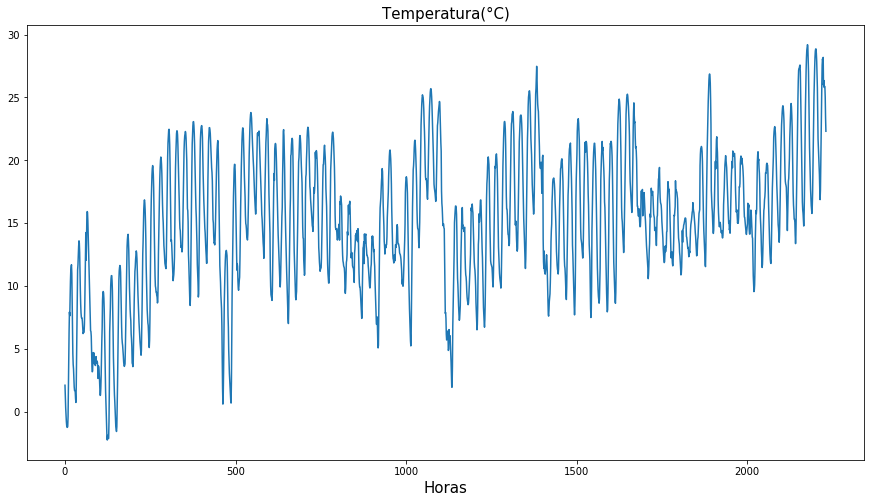

In [65]:
%matplotlib inline
plt.figure(figsize=(15, 8));
plt.title('Temperatura(°C)', fontsize = 15)
plt.plot(df.temp.values)
plt.xlabel('Horas', fontsize = 15)


In [66]:
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

def load_data(stock, seq_len):
    data_raw = np.array(stock) # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    # Choice of the close behavior
    
    x_train = data[:train_set_size,:-1,1]
    y_train = data[:train_set_size,-1,1]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,1]
    
    x_test = data[train_set_size+valid_set_size:,:-1,1]
    y_test = data[train_set_size+valid_set_size:,-1,1]
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    y_train = y_train.reshape(-1,1)
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    y_valid = y_valid.reshape(-1,1)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    y_test = y_test.reshape(-1,1)
    
    np.savetxt('Q6P3_x_train.txt', x_train)
    np.savetxt('Q6P3_y_train.txt', y_train)
    np.savetxt('Q6P3_x_valid.txt', x_valid)
    np.savetxt('Q6P3_y_valid.txt', y_valid)
    np.savetxt('Q6P3_x_test.txt', x_test)
    np.savetxt('Q6P3_y_test.txt', y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

Iremos definir uma sequencia de 24 horas para a previsão da proxima hora

In [67]:
from sklearn.preprocessing import MinMaxScaler

seq_len = 24
sc = MinMaxScaler(feature_range=(0,1))
df.temp = sc.fit_transform(df.temp.values.reshape(-1,1))
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df, seq_len)
print('x_train.shape = ',x_train.shape)
print(x_train[0])
print('y_train.shape = ', y_train.shape)
print(y_train[0])
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1765, 24)
[0.13858867469726177 0.1087094706868004 0.0820088984484279
 0.06134774202521172 0.04672600237074368 0.03623649234802639
 0.03210426112695595 0.03210426112695595 0.03432930552889294
 0.05975842296052789 0.13350285483458368 0.2139224316754162
 0.27495231134986536 0.3235854846465455 0.3140495759799934
 0.3639542241088394 0.4020978969187204 0.42943419576580183
 0.43833438608810743 0.44342020912942487 0.4211697333236609
 0.3541004419662867 0.26636998496764214 0.21837252365792964]
y_train.shape =  (1765, 1)
[0.19135409192956998]
x_valid.shape =  (221, 24)
y_valid.shape =  (221, 1)
x_test.shape =  (221, 24)
y_test.shape =  (221, 1)


### Sintetizando o Preditor Linear

In [68]:
from sklearn.linear_model import LinearRegression

nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
lr = LinearRegression()
lr.fit(X, y_train)
w = lr.coef_[0]
print('Coeficientes do preditor linear')
print(w)

Coeficientes do preditor linear
[-0.17671827  0.14818043  0.01309682  0.03524825  0.03236369 -0.05172346
  0.04305679 -0.06973213  0.03949686  0.03666347 -0.00574159  0.02733404
 -0.01967246 -0.02618591 -0.00936151  0.02250701 -0.00544876 -0.0375169
  0.04145379 -0.05372618  0.05433977 -0.03830873 -0.52387377  1.50964429
  0.        ]


Podemos observar que o Preditor da mais importância aos ultimos valores da sequência

In [69]:
from sklearn.metrics import mean_squared_error

print('EQM final de treinamento após o término do treinamento - Preditor Linear')
nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
y_pred = X.dot(w)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Linear')
nr,nc = x_valid.shape
B = np.ones((nr,1))
X = np.hstack((x_valid,B))
y_pred = X.dot(w)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Linear')
nr,nc = x_test.shape
B = np.ones((nr,1))
X = np.hstack((x_test,B))
y_pred = X.dot(w)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)


EQM final de treinamento após o término do treinamento - Preditor Linear
0.00046122010820435783
EQM final de validação após o término do treinamento - Preditor Linear
0.0005289855465754387
EQM final de teste após o término do treinamento - Preditor Linear
0.0003891440692903924


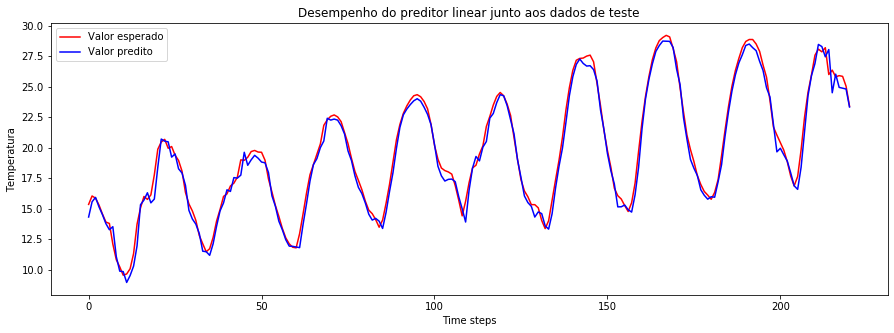

In [70]:
y_pred = X.dot(w)
y_pred = y_pred.reshape(-1, 1)
predicted_temperature = sc.inverse_transform(y_pred)
real_test = sc.inverse_transform(y_test_l)

plt.figure(figsize=(15, 5));
plt.plot(real_test, color='red', label='Valor esperado')
plt.plot(predicted_temperature , color='blue', label='Valor predito')
plt.title('Desempenho do preditor linear junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Temperatura')
plt.legend(loc='best')
plt.show()

### Implementando um Preditor não-linear Simple RNN

In [71]:
x_train_l = np.asarray(x_train,dtype=np.float)
if len(x_train_l.shape) < 3:
    x_train_l = np.expand_dims(x_train_l, axis=2)
y_train_l = np.asarray(y_train,dtype=np.float)
y_train_l = y_train_l.reshape(-1,1)

x_valid_l = np.asarray(x_valid,dtype=np.float)
if len(x_valid_l.shape) < 3:
    x_valid_l = np.expand_dims(x_valid_l, axis=2)
y_valid_l = np.asarray(y_valid,dtype=np.float)
y_valid_l = y_valid_l.reshape(-1,1)

x_test_l = np.asarray(x_test,dtype=np.float)
if len(x_test_l.shape) < 3:
    x_test_l = np.expand_dims(x_test_l, axis=2)
y_test_l = np.asarray(y_test,dtype=np.float)
y_test_l = y_test_l.reshape(-1,1)


print(x_train_l.shape)
print(y_train_l.shape)
print(x_valid_l.shape)
print(y_valid_l.shape)
print(x_test_l.shape)
print(y_test_l.shape)

(1765, 24, 1)
(1765, 1)
(221, 24, 1)
(221, 1)
(221, 24, 1)
(221, 1)


#### Nesta etapa de treinamento iremos regularizar o modelo de duas formas, definindo um EarlyStopping caso o erro de validação não melhore após 10 epochs e definind modelos de checkpoint, para após o termino do treinamento, utilizar o modelo que alcançou o menor erro de validação

In [72]:
EPOCHS = 100
model_RNN_t = keras.models.Sequential([
    keras.layers.SimpleRNN(24, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(24),
    keras.layers.Dense(1)
])
model_RNN_t.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10) 
best_val = ModelCheckpoint('model_RNN_t_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN_t.fit(x_train_l,
          y_train_l,
          epochs=EPOCHS,
          validation_data=(x_valid_l, y_valid_l),
          callbacks=[earlystop, best_val],
          verbose=1)

Train on 1765 samples, validate on 221 samples
Epoch 1/100
1765/1765 [==============================] - 3s 2ms/sample - loss: 0.0356 - val_loss: 0.0024
Epoch 2/100
1765/1765 [==============================] - 1s 689us/sample - loss: 0.0039 - val_loss: 0.0016
Epoch 3/100
1765/1765 [==============================] - 1s 650us/sample - loss: 0.0024 - val_loss: 0.0011
Epoch 4/100
1765/1765 [==============================] - 1s 650us/sample - loss: 0.0016 - val_loss: 7.6910e-04
Epoch 5/100
1765/1765 [==============================] - 1s 647us/sample - loss: 0.0011 - val_loss: 6.9314e-04
Epoch 6/100
1765/1765 [==============================] - 1s 629us/sample - loss: 0.0010 - val_loss: 8.7180e-04
Epoch 7/100
1765/1765 [==============================] - 1s 659us/sample - loss: 9.5722e-04 - val_loss: 5.8025e-04
Epoch 8/100
1765/1765 [==============================] - 1s 658us/sample - loss: 8.5959e-04 - val_loss: 5.7383e-04
Epoch 9/100
1765/1765 [==============================] - 1s 633us/sampl

In [73]:
model_RNN_t.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, None, 24)          624       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 24)                1176      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 1,825
Trainable params: 1,825
Non-trainable params: 0
_________________________________________________________________


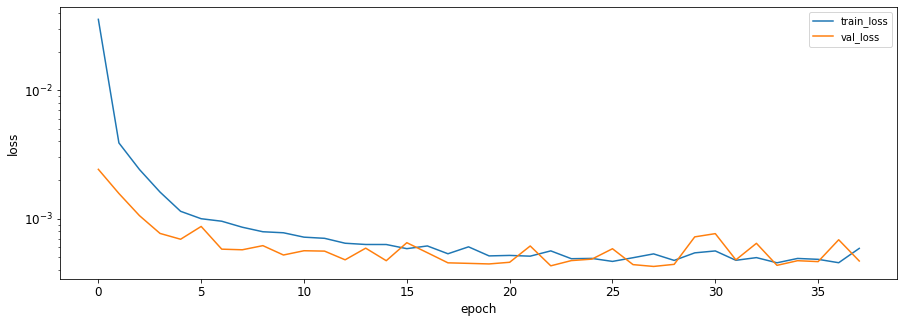

In [74]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN_t.load_weights("model_RNN_t_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [75]:
print('EQM final de treinamento após o término do treinamento - Preditor CNN')
y_pred = model_RNN_t.predict(x_train_l)
MSE_train = mean_squared_error(y_train_l,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor CNN')
y_pred = model_RNN_t.predict(x_valid_l)
MSE_valid = mean_squared_error(y_valid_l,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor CNN')
y_pred = model_RNN_t.predict(x_test_l)
MSE_test = mean_squared_error(y_test_l,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor CNN
0.0004344587743578465
EQM final de validação após o término do treinamento - Preditor CNN
0.0004256798495141361
EQM final de teste após o término do treinamento - Preditor CNN
0.0003712057190865089


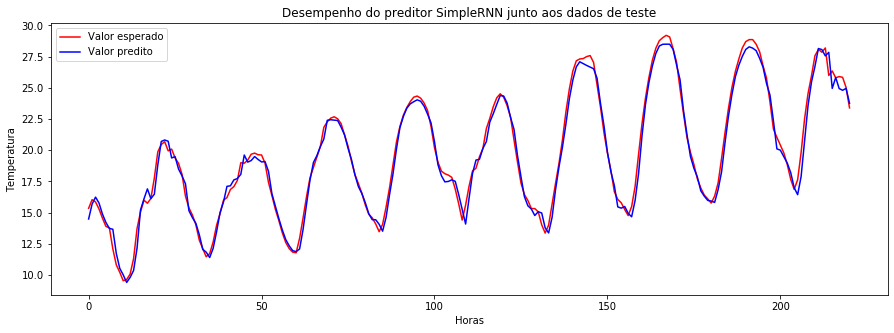

In [76]:
y_pred = model_RNN_t.predict(x_test_l)
predicted_temperature = sc.inverse_transform(y_pred)
real_test = sc.inverse_transform(y_test_l)
plt.figure(figsize=(15, 5));
plt.plot(real_test, color='red', label='Valor esperado')
plt.plot(predicted_temperature, color='blue', label='Valor predito')
plt.title('Desempenho do preditor SimpleRNN junto aos dados de teste')
plt.xlabel('Horas')
plt.ylabel('Temperatura')
plt.legend(loc='best')
plt.show()

### Análise dos resultados

Comparando os métodos, observamos que tiveram resultados similares e satisfatórios para prever a temperatura por hora em Basel-Suíça.

O modelo não-linear SimpleRNN obteve melhor performance nos resultados. Quando comparamos os erros quadrátricos médios dos dois modelos, o modelo não-linear se destacou com um erro menor em todos os dados. Entretanto os 2 métodos se demonstraram com grande performance na previsão de temperatura.

## Bônus: Realizar a predição de temperatura com dados de São Paulo

## Dados do dia 12 ao 26 de Junho de 2020

Text(0.5, 0, 'Horas (12/Jun - 26/Jun 2020)')

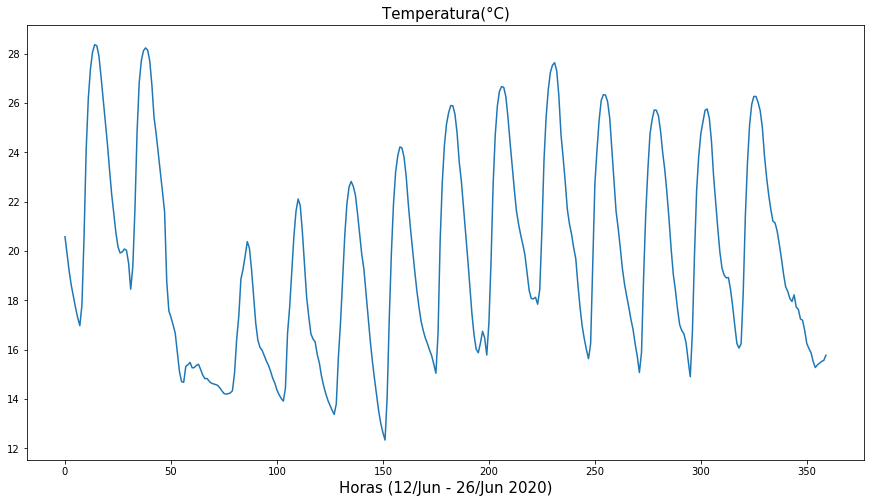

In [77]:
df = pd.read_csv('temperature/sp_m.csv')
plt.figure(figsize=(15, 8));
plt.title('Temperatura(°C)', fontsize = 15)
plt.plot(df.temp.values)
plt.xlabel('Horas (12/Jun - 26/Jun 2020)', fontsize = 15)

In [78]:
valid_set_size_percentage = 10 
test_set_size_percentage = 10 
from sklearn.preprocessing import MinMaxScaler

seq_len = 24
sc = MinMaxScaler(feature_range=(0,1))
df.temp = sc.fit_transform(df.temp.values.reshape(-1,1))
x_train_s, y_train_s, x_valid_s, y_valid_s, x_test_s, y_test_s = load_data(df, seq_len)
print('x_train.shape = ',x_train_s.shape)
print('y_train.shape = ', y_train_s.shape)
print('x_valid.shape = ',x_valid_s.shape)
print('y_valid.shape = ', y_valid_s.shape)
print('x_test.shape = ', x_test_s.shape)
print('y_test.shape = ',y_test_s.shape)

x_train.shape =  (267, 24)
y_train.shape =  (267, 1)
x_valid.shape =  (34, 24)
y_valid.shape =  (34, 1)
x_test.shape =  (34, 24)
y_test.shape =  (34, 1)


In [79]:
from sklearn.linear_model import LinearRegression

nr,nc = x_train_s.shape
B = np.ones((nr,1))
X = np.hstack((x_train_s,B))
lr = LinearRegression()
lr.fit(X, y_train_s)
w = lr.coef_[0]
print('Coeficientes do preditor linear')
print(w)

Coeficientes do preditor linear
[-0.4683093   0.60324071 -0.08662591 -0.06868422  0.02741201  0.03904182
 -0.08058087  0.06020416  0.01152999 -0.05260901  0.0799467  -0.10356144
  0.10977948 -0.16130268  0.15651022 -0.09391999  0.08240372 -0.05556801
 -0.03472057  0.07701353 -0.11385733  0.3432618  -1.06413441  1.76670382
  0.        ]


In [80]:
from sklearn.metrics import mean_squared_error

print('EQM final de treinamento após o término do treinamento - Preditor Linear')
nr,nc = x_train_s.shape
B = np.ones((nr,1))
X = np.hstack((x_train_s,B))
y_pred = X.dot(w)
MSE_train = mean_squared_error(y_train_s,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Linear')
nr,nc = x_valid_s.shape
B = np.ones((nr,1))
X = np.hstack((x_valid_s,B))
y_pred = X.dot(w)
MSE_valid = mean_squared_error(y_valid_s,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Linear')
nr,nc = x_test_s.shape
B = np.ones((nr,1))
X = np.hstack((x_test_s,B))
y_pred = X.dot(w)
MSE_test = mean_squared_error(y_test_s,y_pred)
print(MSE_test)


EQM final de treinamento após o término do treinamento - Preditor Linear
0.0007482506439288507
EQM final de validação após o término do treinamento - Preditor Linear
0.0007375430962758609
EQM final de teste após o término do treinamento - Preditor Linear
0.0007079423225892464


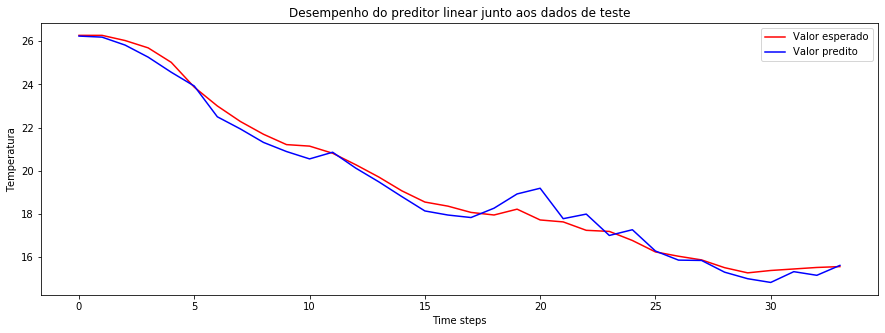

In [81]:
y_pred = X.dot(w)
y_pred = y_pred.reshape(-1, 1)
predicted_temperature = sc.inverse_transform(y_pred)
real_test = sc.inverse_transform(y_test_s)

plt.figure(figsize=(15, 5));
plt.plot(real_test, color='red', label='Valor esperado')
plt.plot(predicted_temperature , color='blue', label='Valor predito')
plt.title('Desempenho do preditor linear junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Temperatura')
plt.legend(loc='best')
plt.show()

In [82]:
x_train_sp = np.asarray(x_train_s,dtype=np.float)
if len(x_train_sp.shape) < 3:
    x_train_sp = np.expand_dims(x_train_sp, axis=2)
y_train_sp = np.asarray(y_train_s,dtype=np.float)
y_train_sp = y_train_sp.reshape(-1,1)

x_valid_sp = np.asarray(x_valid_s,dtype=np.float)
if len(x_valid_sp.shape) < 3:
    x_valid_sp = np.expand_dims(x_valid_sp, axis=2)
y_valid_sp = np.asarray(y_valid_s,dtype=np.float)
y_valid_sp = y_valid_sp.reshape(-1,1)

x_test_sp = np.asarray(x_test_s,dtype=np.float)
if len(x_test_sp.shape) < 3:
    x_test_sp = np.expand_dims(x_test_sp, axis=2)
y_test_sp = np.asarray(y_test_s,dtype=np.float)
y_test_sp = y_test_sp.reshape(-1,1)


print(x_train_sp.shape)
print(y_train_sp.shape)
print(x_valid_sp.shape)
print(y_valid_sp.shape)
print(x_test_sp.shape)
print(y_test_sp.shape)

(267, 24, 1)
(267, 1)
(34, 24, 1)
(34, 1)
(34, 24, 1)
(34, 1)


In [83]:
model_RNN_t.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10) 
best_val = ModelCheckpoint('model_RNN_sp_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN_t.fit(x_train_sp,
          y_train_sp,
          epochs=EPOCHS,
          validation_data=(x_valid_sp, y_valid_sp),
          callbacks=[earlystop, best_val],
          verbose=1)

Train on 267 samples, validate on 34 samples
Epoch 1/100
267/267 [==============================] - 2s 9ms/sample - loss: 0.0072 - val_loss: 0.0058
Epoch 2/100
267/267 [==============================] - 0s 834us/sample - loss: 0.0030 - val_loss: 0.0035
Epoch 3/100
267/267 [==============================] - 0s 822us/sample - loss: 0.0022 - val_loss: 0.0017
Epoch 4/100
267/267 [==============================] - 0s 803us/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 5/100
267/267 [==============================] - 0s 778us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 6/100
267/267 [==============================] - 0s 782us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 7/100
267/267 [==============================] - 0s 803us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 8/100
267/267 [==============================] - 0s 725us/sample - loss: 0.0011 - val_loss: 0.0013
Epoch 9/100
267/267 [==============================] - 0s 823us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 10/100

267/267 [==============================] - 0s 775us/sample - loss: 7.9909e-04 - val_loss: 6.6532e-04
Epoch 75/100
267/267 [==============================] - 0s 724us/sample - loss: 8.8957e-04 - val_loss: 5.1684e-04
Epoch 76/100
267/267 [==============================] - 0s 728us/sample - loss: 6.7526e-04 - val_loss: 7.2486e-04
Epoch 77/100
267/267 [==============================] - 0s 721us/sample - loss: 6.9058e-04 - val_loss: 5.3627e-04
Epoch 78/100
267/267 [==============================] - 0s 719us/sample - loss: 6.8063e-04 - val_loss: 5.6117e-04
Epoch 79/100
267/267 [==============================] - 0s 724us/sample - loss: 8.1426e-04 - val_loss: 5.3154e-04
Epoch 80/100
267/267 [==============================] - 0s 687us/sample - loss: 6.9861e-04 - val_loss: 7.1488e-04
Epoch 81/100
267/267 [==============================] - 0s 695us/sample - loss: 7.4737e-04 - val_loss: 5.2951e-04
Epoch 82/100
267/267 [==============================] - 0s 788us/sample - loss: 6.4211e-04 - val_loss

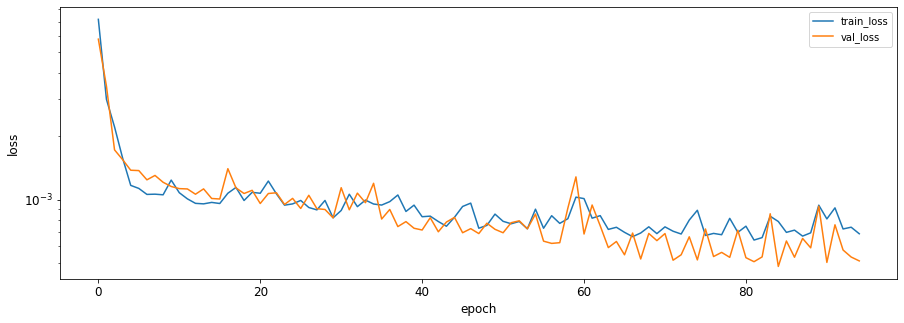

In [84]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN_t.load_weights("model_RNN_sp_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [85]:
print('EQM final de treinamento após o término do treinamento - Preditor CNN')
y_pred = model_RNN_t.predict(x_train_sp)
MSE_train = mean_squared_error(y_train_sp,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor CNN')
y_pred = model_RNN_t.predict(x_valid_sp)
MSE_valid = mean_squared_error(y_valid_sp,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor CNN')
y_pred = model_RNN_t.predict(x_test_sp)
MSE_test = mean_squared_error(y_test_sp,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor CNN
0.000627177680486236
EQM final de validação após o término do treinamento - Preditor CNN
0.0004811487483613324
EQM final de teste após o término do treinamento - Preditor CNN
0.000692458362926922


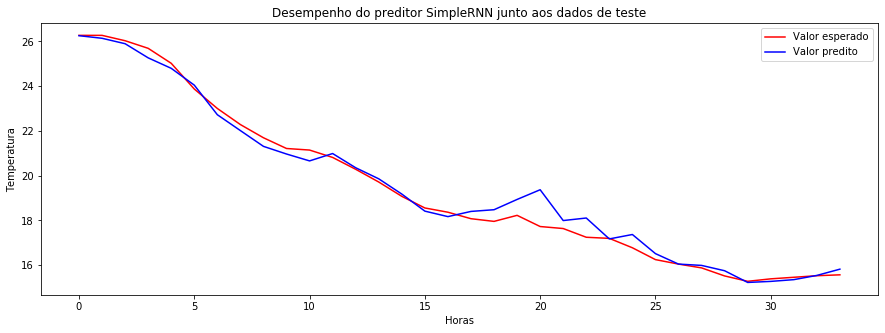

In [86]:
y_pred = model_RNN_t.predict(x_test_sp)
predicted_temperature = sc.inverse_transform(y_pred)
real_test = sc.inverse_transform(y_test_sp)
plt.figure(figsize=(15, 5));
plt.plot(real_test, color='red', label='Valor esperado')
plt.plot(predicted_temperature, color='blue', label='Valor predito')
plt.title('Desempenho do preditor SimpleRNN junto aos dados de teste')
plt.xlabel('Horas')
plt.ylabel('Temperatura')
plt.legend(loc='best')
plt.show()

Por fim, com menos dados para o treinamento e análise. O preditor linear e o não-linear tiveram resultados semelhantes, tanto graficamente como no Erro Quadrático Médio.